In [1]:
import tensorflow as tf
import dataset_hic
import keras
import h5py
import numpy as np
import seaborn as sns
import pandas as pd

from basenji import dataset

In [2]:
# set paths to all necessary predictions and true labels
targets = "/data/basset_tfr/full_downsampled10p/"
preds_peaks = "/results/basset_model/10peaks/preds.h5"
preds_hic = "/results/basset_model/hic_10p/preds.h5"

In [ ]:
# read targets
data = dataset.SeqDataset(targets,
                              split_label='test',
                              batch_size=64,
                              shuffle_buffer=8192,
                              mode='eval',
                              tfr_pattern=None)
seqs, targets = data.numpy(return_inputs=True, return_outputs=True)

In [ ]:
import json
from basenji import seqnn
params_file = "config/params_basset.json"
with open(params_file) as params_open:
    params = json.load(params_open)
params_model = params['model']
params_train = params['train']



# initialize model
seqnn_model = seqnn.SeqNN(params_model)
seqnn_model.restore("/results/basset_model/basset_wo_chr1/model_best.h5", 0)
seqnn_model.build_ensemble(False, [])

In [47]:
# read targets
data_10p = dataset.SeqDataset("/data/basset_tfr/full_downsampled10p/",
                              split_label='test',
                              batch_size=128,
                              shuffle_buffer=8192,
                              mode='eval',
                              tfr_pattern=None)

THE TFR FILES


In [49]:
from basenji import metrics
seqnn_model.model.compile(optimizer=tf.keras.optimizers.SGD(),
            loss=loss_fn,
            metrics=[metrics.SeqAUC(curve='ROC', summarize=False),
                     metrics.SeqAUC(curve='PR', summarize=False)])

In [ ]:
seqnn_model.model.evaluate(data_10p.dataset)

In [ ]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
test_loss, test_metric1, test_metric2 = seqnn_model.evaluate(x=seqs, y=y, head_i=None, loss='poisson')

In [5]:
# Since hic sequences (and so predictions made on them) were extracted based on a fraction of specific original data set
# for each original peak we collected 62 neighbors, now their prediction scores have to be avaraged
# to achieve same dimension as target and prediction targets peaks
pred_obj_hic = h5py.File(preds_hic)
pred_hic_set = np.array(pred_obj_hic.get('preds'))

In [6]:
pred_hic_set.shape

(119769, 1, 1)

In [5]:
toDimension = []
for i in range(0, len(pred_hic_set), 62):
    hicMean = np.mean(pred_hic_set[i:i+62], axis=0)
    toDimension.append(hicMean)


In [6]:
toDimension = np.asarray(toDimension)
pred_hic_set = toDimension

In [7]:
# lastly store into numpy array a peak preds
pred_obj_peak = h5py.File(preds_peaks)
pred_peak_set = np.array(pred_obj_peak.get('preds'))

In [9]:
# as for Hi-C sequences we only consider one cell type (K562), its predictions
# will be used in further analysis

tg_set_ti = targets[:, :,120]
# tg_set_ti.shape
# # sample every few bins (adjust to plot the # points I want)
ds_indexes = np.arange(0, tg_set_ti.shape[1], 8)

# subset and flatten
tg_ti_flat = tg_set_ti[:, ds_indexes].flatten().astype('float32')
# pred_ti_flat = pred_peak_set[:, ds_indexes, 120].flatten().astype('float32')
# pred_ti_hic_flat = pred_hic_set[:, ds_indexes, 120].flatten().astype('float32')

In [10]:
pred_ti_flat = pred_peak_set[:, :, 120].flatten().astype('float32')
pred_ti_hic_flat = pred_hic_set[:].flatten().astype('float32')

In [11]:
pred_ti_flat.shape

(119769,)

In [12]:
tg_ti_flat.shape

(119769,)

In [13]:
# call peaks
from scipy.stats import poisson
def ben_hoch(p_values):
  """ Convert the given p-values to q-values using Benjamini-Hochberg FDR. """
  m = len(p_values)

  # attach original indexes to p-values
  p_k = [(p_values[k], k) for k in range(m)]

  # sort by p-value
  p_k.sort()

  # compute q-value and attach original index to front
  k_q = [(p_k[i][1], p_k[i][0] * m // (i + 1)) for i in range(m)]

  # re-sort by original index
  k_q.sort()

  # drop original indexes
  q_values = [k_q[k][1] for k in range(m)]

  return q_values

test_targets_ti_lambda = np.mean(tg_ti_flat)
test_targets_pvals = 1 - poisson.cdf(
  np.round(tg_ti_flat) - 1, mu=test_targets_ti_lambda)
test_targets_qvals = np.array(ben_hoch(test_targets_pvals))
test_targets_peaks = test_targets_qvals < 0.01
test_targets_peaks_str = np.where(test_targets_peaks, 'Peak',
                                'Background')

In [14]:
test_targets_peaks = test_targets_peaks.astype(int)

In [14]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

In [ ]:
df = pd.DataFrame({'peaks': pred_ti_flat, 'hic': pred_ti_hic_flat, 'targets': tg_ti_flat})
sns.histplot(data=df)

In [15]:
inds = np.where(test_targets_peaks > 0)
peaks_tgs = tg_ti_flat[inds[0]]
peaks_preds = pred_ti_flat[inds[0]]
hic_preds = pred_ti_hic_flat[inds[0]]

In [ ]:
inds_low = np.where(>test_targets_peaks > 0)

In [91]:
len(peaks_preds[peaks_preds>0.5])

38

In [ ]:
sns.scatterplot(x=peaks_tgs, y=peaks_preds)

In [17]:
from scipy.stats.stats import pearsonr, spearmanr
from sklearn.metrics import confusion_matrix, precision_score, recall_score
%matplotlib inline
import matplotlib
# matplotlib.use('PDF')
import matplotlib.pyplot as plt
#
intensity_matrix = pd.DataFrame({ 'GroundTruth': peaks_tgs,'Basset': peaks_preds, 'HiCBoost': hic_preds})
intensity_matrixT = intensity_matrix.T

In [18]:
# intensity_matrix = pd.DataFrame({ 'GroundTruth': peaks_tgs,'BB': peaks_preds, 'HiCBoost': hic_preds})
log2_intensity = np.log2(intensity_matrix)

<AxesSubplot:ylabel='Count'>

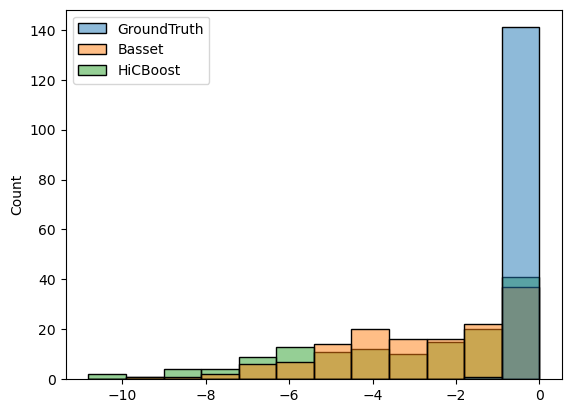

In [22]:
sns.histplot(log2_intensity)

<AxesSubplot:>

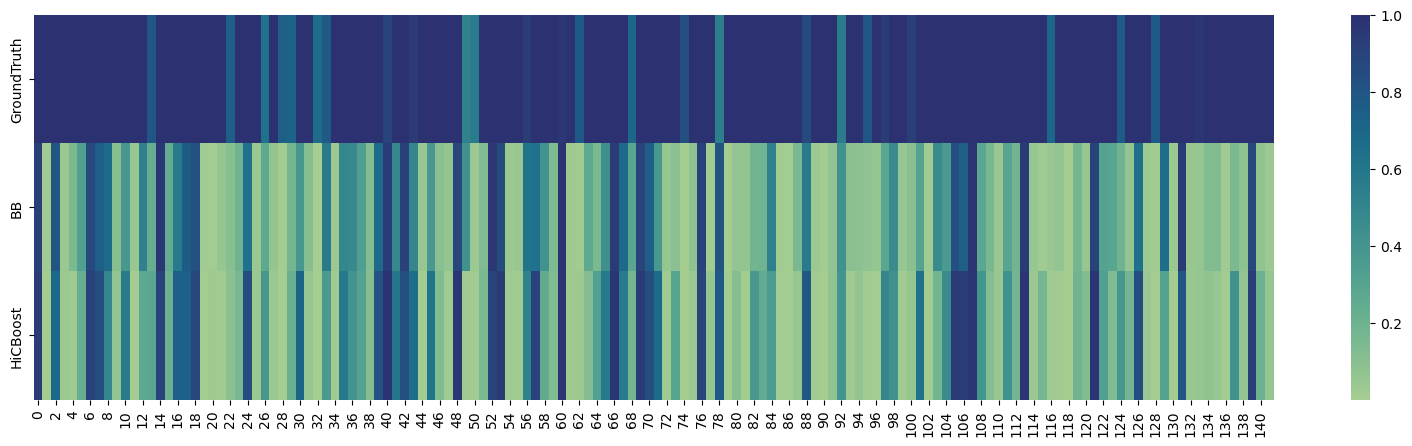

In [48]:
plt.figure(figsize=(20, 5))
sns.heatmap(intensity_matrix, cmap="crest")

In [112]:
test_targets_peaks = test_targets_peaks.astype(int)
test_targets_peaks

array([0, 0, 0, ..., 0, 0, 0])

In [69]:
thresholds = np.arange(0, 1.05 , 0.05)[: : -1]

def metrics(thresh, tgs, preds):
    to_df = {'thresh': list(thresh), 'precision': [], 'recall': [], 'fpr': [], 'tp': [], 'fp': [], 'tn': [], 'fn': []}
    for t in thresh:
        preds_t = ( preds > t ).astype(int)

        # reacll and precision
        prec = precision_score(tgs, preds_t)
        recall = recall_score(tgs, preds_t)
        to_df['precision'].append(prec)
        to_df['recall'].append(recall)
        

        # confusion matrix
        conf_m_peaks = confusion_matrix(tgs, preds_t)
        tn, fp, fn, tp = conf_m_peaks.ravel()
        fpr = fp/(fp+tn)
        to_df['tp'].append(tp)
        to_df['fp'].append(fp)
        to_df['tn'].append(tn)
        to_df['fn'].append(fn)
        to_df['fpr'].append(fpr)


        # conf_m_peaks[0, [0, 1]] = conf_m_peaks[0, [1, 0]]

        # plot matrix for each t
        # sns.heatmap(conf_m_peaks, 
        # annot=True,
        # fmt='g', 
        # xticklabels=['Closed','Open'],
        # yticklabels=['Closed','Open'])
        # plt.ylabel('Actual',fontsize=13)
        # plt.xlabel('Prediction',fontsize=13)
        # plt.title(f'Threshold = {t}',fontsize=17)
        # plt.show()
    df = pd.DataFrame(to_df)
    
    return df

        

In [130]:
test_targets_peaks = test_targets_peaks.astype(int)
test_targets_peaks

array([0, 0, 0, ..., 0, 0, 0])

In [152]:
preds_t = ( pred_ti_flat > 1 ).astype(int)


(array([], dtype=int64),)

In [56]:
thresholds

array([1.000000, 0.950000, 0.900000, 0.850000, 0.800000, 0.750000,
       0.700000, 0.650000, 0.600000, 0.550000, 0.500000, 0.450000,
       0.400000, 0.350000, 0.300000, 0.250000, 0.200000, 0.150000,
       0.100000, 0.050000, 0.000000])

In [ ]:
df_peaks_metrics = metrics(thresholds, test_targets_peaks, pred_ti_flat)

In [ ]:
df_hic_metrics = metrics(thresholds, test_targets_peaks, pred_ti_hic_flat)

In [72]:
print(df_peaks_metrics)

    thresh  precision    recall       fpr   tp      fp      tn   fn
0     1.00   0.000000  0.000000  0.000000    0       0  119627  142
1     0.95   0.032258  0.035211  0.001254    5     150  119477  137
2     0.90   0.038585  0.084507  0.002499   12     299  119328  130
3     0.85   0.039261  0.119718  0.003477   17     416  119211  125
4     0.80   0.038745  0.147887  0.004355   21     521  119106  121
5     0.75   0.033333  0.154930  0.005333   22     638  118989  120
6     0.70   0.032300  0.176056  0.006261   25     749  118878  117
7     0.65   0.032438  0.204225  0.007231   29     865  118762  113
8     0.60   0.031132  0.232394  0.008585   33    1027  118600  109
9     0.55   0.029150  0.253521  0.010023   36    1199  118428  106
10    0.50   0.026010  0.267606  0.011895   38    1423  118204  104
11    0.45   0.025375  0.309859  0.014127   44    1690  117937   98
12    0.40   0.023472  0.338028  0.016694   48    1997  117630   94
13    0.35   0.021440  0.373239  0.020221   53  

In [73]:
print(df_hic_metrics)

    thresh  precision    recall       fpr   tp      fp      tn   fn
0     1.00   0.000000  0.000000  0.000000    0       0  119627  142
1     0.95   0.033457  0.063380  0.002173    9     260  119367  133
2     0.90   0.033827  0.112676  0.003820   16     457  119170  126
3     0.85   0.032626  0.140845  0.004957   20     593  119034  122
4     0.80   0.034674  0.176056  0.005818   25     696  118931  117
5     0.75   0.033333  0.197183  0.006788   28     812  118815  114
6     0.70   0.032666  0.218310  0.007674   31     918  118709  111
7     0.65   0.032197  0.239437  0.008543   34    1022  118605  108
8     0.60   0.031119  0.260563  0.009630   37    1152  118475  105
9     0.55   0.030303  0.288732  0.010967   41    1312  118315  101
10    0.50   0.027541  0.295775  0.012397   42    1483  118144  100
11    0.45   0.025952  0.316901  0.014119   45    1689  117938   97
12    0.40   0.024618  0.352113  0.016560   50    1981  117646   92
13    0.35   0.023275  0.394366  0.019644   56  

In [63]:
df_hic_metrics.precision

0     0.000000
1     0.033457
2     0.033827
3     0.032626
4     0.034674
5     0.033333
6     0.032666
7     0.032197
8     0.031119
9     0.030303
10    0.027541
11    0.025952
12    0.024618
13    0.023275
14    0.021181
15    0.018286
16    0.015808
17    0.013674
18    0.011236
19    0.007608
20    0.001186
Name: precision, dtype: float64

In [84]:
tg_vs_pk = pearsonr(peaks_tgs, peaks_preds)
tg_vs_hic = pearsonr(peaks_tgs,hic_preds)
pk_vs_hic = pearsonr(peaks_preds, hic_preds)

In [75]:
df_nonzero = pd.DataFrame({'peaks': peaks_preds, 'hic': hic_preds, 'targets': peaks_tgs})

In [ ]:
sns.histplot(data=df_nonzero)

In [61]:
test_targets_peaks.astype(int)

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
sns.histplot(data=df, x=np.log2(df.peaks))

In [18]:
x = tf.convert_to_tensor(tg_ti_flat, dtype=tf.float32)
y = tf.convert_to_tensor(pred_ti_flat, dtype=tf.float32)
z = tf.convert_to_tensor(pred_ti_hic_flat, dtype=tf.float32)

In [75]:
# call peaks
from scipy.stats import poisson
def ben_hoch(p_values):
  """ Convert the given p-values to q-values using Benjamini-Hochberg FDR. """
  m = len(p_values)

  # attach original indexes to p-values
  p_k = [(p_values[k], k) for k in range(m)]

  # sort by p-value
  p_k.sort()

  # compute q-value and attach original index to front
  k_q = [(p_k[i][1], p_k[i][0] * m // (i + 1)) for i in range(m)]

  # re-sort by original index
  k_q.sort()

  # drop original indexes
  q_values = [k_q[k][1] for k in range(m)]

  return q_values

test_targets_ti_lambda = np.mean(tg_ti_flat)
test_targets_pvals = 1 - poisson.cdf(
  np.round(tg_ti_flat) - 1, mu=test_targets_ti_lambda)
test_targets_qvals = np.array(ben_hoch(test_targets_pvals))
test_targets_peaks = test_targets_qvals < 0.01
test_targets_peaks_str = np.where(test_targets_peaks, 'Peak',
                                'Background')

In [76]:
test_targets_peaks

array([False, False, False, ..., False, False, False])

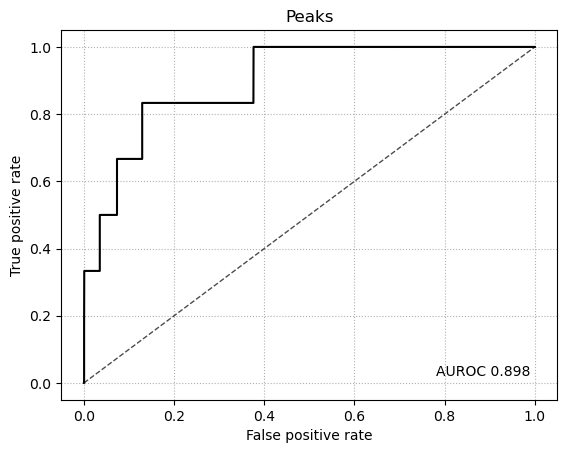

In [14]:
%matplotlib inline
import matplotlib
# matplotlib.use('PDF')
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score

# cases_preds = [pred_ti_flat, pred_avg_ti_flat, pred_hic_ti_flat]
# aurocs = []
# aurprcs = []

# fig, axes = plt.subplots(ncols=3, figsizes=(15,5))

plt.figure()
fpr, tpr, _ = roc_curve(test_targets_peaks, pred_ti_flat)
auroc = roc_auc_score(test_targets_peaks, pred_ti_flat)
auprc = average_precision_score(test_targets_peaks, pred_ti_flat)
plt.title("Peaks") 
plt.plot(
  [0, 1], [0, 1], c='black', linewidth=1, linestyle='--', alpha=0.7)
plt.plot(fpr, tpr, c='black')
ax = plt.gca()
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.text(
  0.99, 0.02, 'AUROC %.3f' % auroc,
  horizontalalignment='right')  # , fontsize=14)
ax.grid(True, linestyle=':')
plt.show()

In [15]:
# transform to log2
tg_ti_flat_log = np.log2(tg_ti_flat, where=0<tg_ti_flat, out=0*tg_ti_flat)
pred_ti_flat_log = np.log2(pred_ti_flat, where=0<pred_ti_flat, out=0*pred_ti_flat)
pred_ti_hic_flat_log = np.log2(pred_ti_hic_flat, where=0<pred_ti_hic_flat, out=0*pred_ti_hic_flat)

In [169]:
dupa = np.log2(tg_ti_flat, where=0<tg_ti_flat, out=0*tg_ti_flat)

In [ ]:
pred_ti_flat_log[tg_ti_flat_log != 0]

In [ ]:
inds = [tg_ti_flat_log != 0]
tg_ti_flat_log =tg_ti_flat_log[inds]
pred_ti_flat_log = pred_ti_flat_log[inds]
pred_ti_hic_flat_log = pred_ti_hic_flat_log[inds]

In [82]:
from scipy.stats.stats import pearsonr, spearmanr

In [117]:
# calcualte correlation (pearsonR)
# target vs peaks preds
# target vs hic preds
# peaks preds vs hic preds

#pred_ti_flat.iloc[pred_ti_flat > 0]
inds = np.asarray(tg_ti_flat>0).nonzero()
tg_ti_flat = tg_ti_flat[inds]
pred_ti_flat = pred_ti_flat[inds]
pred_ti_hic_flat = pred_ti_hic_flat[inds]
# tg_vs_pk = pearsonr(list(tg_ti_flat),list(pred_ti_flat))
# tg_vs_hic = pearsonr(list(tg_ti_flat),list(pred_ti_hic_flat))
# pk_vs_hic = pearsonr(list(pred_ti_flat),list(pred_ti_hic_flat))

In [116]:
inds

array([False,  True, False, ..., False, False, False])

In [126]:
a = np.log2(tg_ti_flat)
b =np.log2(pred_ti_flat)
c = np.log2(pred_ti_hic_flat)

In [127]:
tg_vs_pk = spearmanr(list(a),list(b))
tg_vs_hic = spearmanr(list(a),list(c))
pk_vs_hic = spearmanr(list(b),list(c))

In [128]:
summ_df = pd.DataFrame({ 'Target': list(a) , 'Peaks_Predictions': list(b), 'Neighbors_Predictions': c})

In [129]:
print(round(tg_vs_pk[0], 3))
print(round(tg_vs_hic[0], 3))
print(round(pk_vs_hic[0], 3))

0.145
0.061
0.258


In [130]:
summ_df

,Target,Peaks_Predictions,Neighbors_Predictions
0,-1.292641,-4.369733,-5.286613
1,0.000000,-0.698504,-3.687117
2,-0.168693,-1.267833,-4.744971
3,0.000000,-0.779622,-4.712287
4,0.000000,-0.315251,-4.137362
...,...,...,...
107,0.000000,-3.270379,-3.791766
108,0.000000,-6.256007,-4.854068
109,0.000000,-4.181418,-4.507145
110,0.000000,-0.036381,-4.282323


<AxesSubplot:xlabel='Target', ylabel='Peaks_Predictions'>

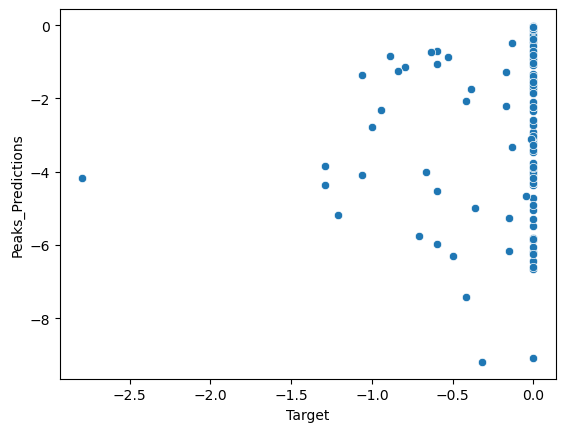

In [131]:
import matplotlib.pyplot as plt

# fig, ax = plt.subplots() 


sns.scatterplot(data=summ_df, x='Target', y='Peaks_Predictions')

In [88]:
summ_df.columns[1]

'Peaks_Predictions'

In [89]:
summ_df.Peaks_Predictions

0     -4.369733
1     -0.698504
2     -1.267833
3     -0.779622
4     -0.315251
         ...   
107   -3.270379
108   -6.256007
109   -4.181418
110   -0.036381
111   -2.238449
Name: Peaks_Predictions, Length: 112, dtype: float32

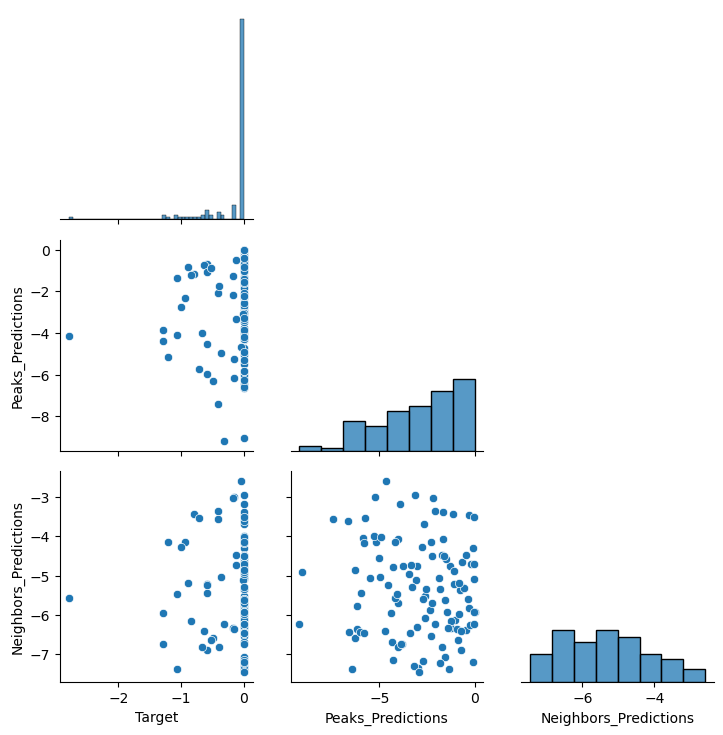

In [90]:
g = sns.PairGrid(summ_df, corner=True, palette='black')
g.map_offdiag(sns.scatterplot)
g.map_diag(sns.histplot)

In [108]:
from keras import backend as K

def pearson_r(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = np.mean(x)
    my = np.mean(y)
    xm, ym = x - mx, y - my
    r_num = np.sum(xm * ym)
    x_square_sum = np.sum(xm * xm)
    y_square_sum = np.sum(ym * ym)
    r_den = np.sqrt(x_square_sum * y_square_sum)
    r = r_num / r_den
    return np.mean(r)

In [121]:
pearson_r(b, c)

0.25147435

## Motif analysis

In [89]:
# First take motifs from peaks and from Hi-C sequences
motifs_org = '/raid/dkokot/results/basset_model/tomtom.tsv'
motifs_cust = '/raid/dkokot/results/basset_model/tomtom_hic.tsv'

In [95]:
motifs_org = pd.read_csv(motifs_org, sep='\t')
motifs_cust = pd.read_csv(motifs_cust, sep='\t')

In [96]:
motifs_org.drop(motifs_org.tail(3).index,inplace=True)

In [98]:
motifs_cust.drop(motifs_cust.tail(3).index,inplace=True)

motifs_cust

In [105]:
motifs_cust['Query_ID']

0        filter2
1        filter3
2        filter3
3        filter3
4        filter5
         ...    
683    filter282
684    filter282
685    filter282
686    filter282
687    filter285
Name: Query_ID, Length: 688, dtype: object

In [106]:
motifs_org['Query_ID']

0        filter2
1        filter4
2        filter5
3       filter11
4       filter12
         ...    
679    filter282
680    filter282
681    filter282
682    filter282
683    filter285
Name: Query_ID, Length: 684, dtype: object

In [112]:
#merge two DataFrames and create indicator column
motifs_all = motifs_cust.merge(motifs_org, on=['Query_ID'],
                   how='left', indicator=True)

#create DataFrame with rows that exist in first DataFrame only
motifs_cust_only = motifs_all[motifs_all['_merge'] == 'left_only']

In [ ]:
cols = [i for i in range(10, len(motifs_cust_only.columns))]
motifs_cust_only.drop(motifs_cust_only.columns[cols], axis=1, inplace=True)

In [ ]:
motifs_cust_only

In [123]:
filters_unique = motifs_cust_only.Query_ID.unique()
target_unique = motifs_cust_only.Target_ID_x.unique()

In [136]:
len(filters_unique)

11

In [137]:
len(target_unique)

22

In [135]:
motifs_cust_only.to_csv('new_motifs_hic.tsv', sep="\t")

### Evaluate HiCBoost model trained on 5% without chromosome 1 with 10% of data containing all chromosomes
### This would test whether such model truly outperformed version of model trained on bigger size of data.

In [23]:
# load model
import layers

model_dir_hic_5p_wo1 = "/data/basset_model/wo_chr1_hic/model_best.h5"
model_hic_from_dir_5p_wo1 = tf.keras.models.load_model(model_dir_hic_5p_wo1, custom_objects={'StochasticReverseComplement': layers.StochasticReverseComplement(),  
                                                                  'SwitchReverse': layers.SwitchReverse(), 'StochasticShift': layers.StochasticShift}, compile=False)

In [24]:
data_path = "/data/basset_tfr/full_downsampled10p/"
data_hic = dataset_hic.SeqDataset(data_path,
                              split_label='test',
                              batch_size=32,
                              shuffle_buffer=8192,
                              hic_length=25000,
                              cell_id=120,
                              mode='eval',
                              tfr_pattern=None)

In [31]:
# evaluate
import trainer
loss_label = params_train.get('loss', 'poisson').lower()
spec_weight = params_train.get('spec_weight', 1)
loss_fn = trainer.parse_loss(loss_label, spec_weight=spec_weight)

In [32]:
def evaluate_model(model_object, seq_data, head_i=None, loss_label='poisson', loss_fn=None):
    """ Evaluate model on SeqDataset. """
    model = model_object

    # compile with dense metrics
    num_targets = model.output_shape[-1]

    if loss_fn is None:
        loss_fn = loss_label
    
    if loss_label == 'bce':
        model.compile(optimizer=tf.keras.optimizers.SGD(),
                    loss=loss_fn,
                    metrics=[metrics.SeqAUC(curve='ROC', summarize=False),
                             metrics.SeqAUC(curve='PR', summarize=False)])
    else:      
        model.compile(optimizer=tf.keras.optimizers.SGD(),
                    loss=loss_fn,
                    metrics=[metrics.PearsonR(num_targets, summarize=False),
                             metrics.R2(num_targets, summarize=False)])

    # evaluate
    return model.evaluate(seq_data.dataset)

In [34]:
import metrics
test_loss_hic, test_metric1_hic, test_metric2_hic = evaluate_model(model_hic_from_dir_5p_wo1, data_hic, loss_label=loss_label, loss_fn=loss_fn)

2023-12-19 20:14:12.893658: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2023-12-19 20:14:13.328896: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


3743/3743 [==============================] - 1714s 452ms/step - loss: 0.0950 - auroc: 0.9014 - auprc: 0.4485
